# Region Comparison for Netflix Movies & TV Shows

## Set Up Environment

In [1]:
# Import libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read CSV file into a pandas dataframe.
netflix_data = pd.read_csv('data/netflix_titles.csv', index_col='show_id')

## Define Classes

In [3]:
class Data_Processing:
    """
    The Data_Processing class is for applying a series of data-cleaning steps to a dataframe.  This is to prepare the data
    for further analysis.
    
    Attributes:
        data: The dataframe that is passed in and that the data-cleaning steps are applied to.
    """
    
    def __init__(self, df):
        """The class constructor method takes in a dataframe and saves it as an attribute."""
        self.data = df
    
    def fillna(self, col, value):
        """This method replaces missing values for the column that is passed in with the value that is passed in."""
        self.data[col].fillna(value, inplace=True)
    
    def convert_to_date(self, col):
        """This method converts data for the column that is passed in to a datetime format."""
        self.data[col] = pd.to_datetime(self.data.date_added)
    
    def extract_year(self, col, new_col, datatype):
        """This method takes an existing datetime column, extracts the year, and saves the year in a new column."""
        self.data[new_col] = round(self.data[col].dt.year.astype(datatype, errors='ignore'), 0)
    
    def transform(self, col, new_col, function):
        """This method applies the function that is passed in to an existing column and saves the result in a new column."""
        self.data[new_col] = self.data[col].apply(function)
    
    def rename_columns(self, dic):
        """This method renames the columns in the keys of the dictionary that is passed in as the values at those keys."""
        self.data.rename(columns=dic, inplace=True)
    
    def generate_list(self, col):
        """This method takes a column with lists as values and creates a unique list of the items in the lists of that
        column."""
        new_list = []
        for entry in list(self.data[col]):
            for x in entry:
                if x not in new_list:
                    new_list.append(x)
        return new_list
    
    def _convert_to_list(self, text):
        """This method takes text that is passed in, splits it into a list of each the text, separated by commas."""
        if ',' not in text:
            return [text]
        else:
            converted_text = text.split(',')
            for x in converted_text:
                converted_text[converted_text.index(x)] = x.strip()
            return converted_text

In [4]:
class Region:
    """
    The Region class is for a specified region of the world, represented by a set of countries defined when an object is
    instantiated.  The methods generate metrics and create graphs showing data for that region.
    
    Attributes:
        data: The dataframe that is passed in.
        countries: The list of countries that defines the region.
        name: The name that is passed in for the region.
        regional_data: The dataframe for the specific region.  This is a subset of the data attribute.
        tv_data: The dataframe for the TV shows from the region.
        movie_data: The dataframe for the movies from the region.
        profile: A set of metrics for the region, saved in a dictionary format.
    """
    
    def __init__(self, df, country_list, name):
        """The constructor method takes in a dataframe, a list of countries, and a name of the region and saves them as
        attributes."""
        
        self.data = df
        self.countries = country_list
        self.name = name
        self.regional_data = pd.DataFrame()
        self.tv_data = pd.DataFrame()
        self.movie_data = pd.DataFrame()
        self.profile = {}
    
    def create_regional_df(self):
        """This method creates a subset dataframe that has at least one of the countries from the countries attribute in the 
        country column of the main dataframe passed in when the object is instantiated."""
        
        regex_pattern = ''
        for c in self.countries[:-1]:
            regex_pattern = regex_pattern + c + '|'
        regex_pattern = regex_pattern + self.countries[-1]
        self.regional_data = self.data[self.data.country.str.contains(regex_pattern, regex=True)].copy()
    
    def gen_freq_table(self, df, col, normalize=True):
        """This method creates a frequency table for the column that is passed in."""
        return round(df[col].value_counts(normalize=normalize) * 100, 2)
    
    def split_df(self):
        """This method splits the dataframe for the region into TV data and movie data, and turns the duration column from
        the movie dataframe into an integer."""
        
        self.tv_data = self.regional_data[self.regional_data.type == 'TV Show'].copy()
        self.movie_data = self.regional_data[self.regional_data.type == 'Movie'].copy()
        self.movie_data['duration'] = self.movie_data.duration.str.replace(' min', '').astype('int')
    
    def calc_avg(self, df, col):
        """This method calculates the mean value for the column that is passed in."""
        return round(df[col].mean(), 2)
    
    def graph_freq_dist_by_genre(self, df, new_col, n):
        """This method calculates a frequency distribution and displays the results in a horizontal bar chart."""
        
        count_by_genre = {}
        for g in genres_list:
            indexes = []
            for i in list(df.index):
                genres = df.loc[i, 'listed_in_list']
                if g in genres:
                    indexes.append(i)
            subset_df = df.loc[indexes, :]
            count = len(subset_df)
            count_by_genre[g] = count

        genre_df = pd.DataFrame(pd.Series(count_by_genre), columns=[new_col])
        genre_df.drop(genre_df[genre_df[new_col] == 0].index.tolist(), inplace=True)
        
        genre_df[new_col].sort_values().tail(n).plot.barh(figsize=(6,6), title='Top Genres in {}'.format(self.name))
    
    def generate_profile(self, agg_list, agg_key):
        """This method calculates a set of metrics and saves it to the profile attribute."""
        
        self.profile['show_dist'] = dict(round(self.gen_freq_table(self.regional_data, 'type'), 2))
        self.profile['avg_movie_length'] = round(self.calc_avg(self.movie_data, 'duration'), 2)
        
        initial_dict = dict(round(self.gen_freq_table(self.tv_data, 'duration'), 2))
        new_dict = self._aggregate_dictionary(initial_dict, agg_list, agg_key)
        self.profile['tv_length_dist'] = new_dict
        
        self.profile['avg_director_count'] = round(self.calc_avg(self.regional_data, 'director_size'), 2)
        self.profile['avg_cast_size'] = round(self.calc_avg(self.regional_data, 'cast_size'), 2)
        self.profile['avg_country_count'] = round(self.calc_avg(self.regional_data, 'country_size'), 2)
        self.profile['avg_genre_count'] = round(self.calc_avg(self.regional_data, 'listed_in_size'), 2)
        self.profile['first_year_on_netflix'] = min(self.regional_data.year_added)
        self.profile['release_year_span'] = (min(self.regional_data.release_year), max(self.regional_data.release_year))
    
    def _aggregate_dictionary(self, dictionary, agg_list, agg_key):
        """This method takes the dictionary that is passed in, aggregates the values at the keys in the agg_list into 1
        value, adds that aggregate value to the dictionary, and returns the dictionary."""
        agg_val = 0
        for a in agg_list:
            if a in dictionary:
                agg_val += dictionary[a]
                del dictionary[a]
        if agg_val > 0:
            dictionary[agg_key] = agg_val
        return dictionary

In [5]:
class Comparison:
    """
    The Comparison class is for comparing the regions created using the Region class.
    
    Attributes:
        profiles: The list of profiles from the Region class that is passed in.
        compare_df: A dataframe representation of the profiles attribute.
    """
    
    def __init__(self, profile_list):
        """The constructor method takes in a list of profiles from the Region class and saves it as an attribute.  This list
        represents the regions to be compared using metrics and graphs generated from the attributes and methods of this
        class."""
        
        self.profiles = profile_list
        self.compare_df = pd.DataFrame()
    
    def create_df(self, index):
        """This method creates a dataframe from the profiles attribute."""
        self.compare_df = pd.DataFrame(self.profiles, index=index)
    
    def plot_bar(self, col):
        """This method creates a horizontal bar chart of the column that is passed in."""
        self.compare_df[col].plot.barh(title = '{} by Region'.format(col))
        plt.subplots_adjust(left=.25)
    
    def plot_timeline(self):
        """This method creates a scatter plot showing when a each region joined Netflix."""
        new_df = self.compare_df.reset_index()
        new_df.plot.scatter(x='first_year_on_netflix', y='index', title='Year Region Joined Netflix')
        plt.subplots_adjust(left=.25)
    
    def calc_range(self):
        """This method calculates the range of years the Netflix content for each region spans."""
        self.compare_df['range'] = 0
        for index, row in self.compare_df.iterrows():
            self.compare_df.loc[index, 'range'] = row.release_year_span[1] - row.release_year_span[0]
    
    def plot_stacked_bar(self, col):
        """This method creates a stacked bar chart for the column that is passed in."""
        temp_df = pd.DataFrame.from_dict(dict(self.compare_df[col]), orient='index')
        temp_df.plot.barh(stacked=True, cmap='Accent', title='{} by Region'.format(col))
        plt.subplots_adjust(left=.25)

## Prepare Data

Run the dataframe through the data cleaning steps using the Data_Processing class.

In [6]:
# Instantiate a Data_Processing object.
netflix = Data_Processing(netflix_data)

# Fill the missing values in the text columns with 'Unknown'.
na_fill_cols = ['director', 'cast', 'country', 'rating']
for c in na_fill_cols:
    netflix.fillna(c, 'Unknown')

# Change the 'date_added' column to a datetime object and extract the year from it in a new column.
netflix.convert_to_date('date_added')
netflix.extract_year('date_added', 'year_added', 'int')

# Convert the columns with multiple values into list format and save them in new columns.
list_columns = ['director', 'cast', 'country', 'listed_in']
for c in list_columns:
    netflix.transform(c, '{}_list'.format(c), netflix._convert_to_list)

# Use the list-format columns to calculate the number of items in each cell and save in new size columns.
new_list_columns = ['director_list', 'cast_list', 'country_list', 'listed_in_list']
size_func = lambda x: len(x)
for c in new_list_columns:
    netflix.transform(c, '{}_size'.format(c), size_func)

# Rename the size columns.
new_column_names = {
    'director_list_size': 'director_size',
    'cast_list_size': 'cast_size',
    'country_list_size': 'country_size',
    'listed_in_list_size': 'listed_in_size'
}
netflix.rename_columns(new_column_names)

# Create a unique list of countries and genres.
countries_list = netflix.generate_list('country_list')
genres_list = netflix.generate_list('listed_in_list')

## Define Regions

These are the regions I will compare using different metrics to identify unique characteristics of its content.

### Regions:
- Africa
- Latin America
- Asia & The Pacific
- Middle East
- Europe
- North America

In [7]:
# Set up lists that define each region with the countries it will be composed of.

regions = [
    'Africa',
    'Latin America',
    'Asia & The Pacific',
    'Middle East',
    'Europe',
    'North America'
]

african_countries = [
    'Egypt',
    'Nigeria',
    'South Africa',
    'Kenya',
    'Mauritius',
    'Algeria',
    'Senegal',
    'Ghana',
    'Namibia',
    'Zimbabwe',
    'Morocco',
    'Botswana',
    'Angola',
    'Malawi',
    'Somalia',
    'Sudan',
    'Uganda'
]

latin_american_countries = [
    'Brazil',
    'Mexico',
    'Argentina',
    'Uruguay',
    'Chile',
    'Colombia',
    'Peru',
    'Bahamas',
    'Cayman Islands',
    'Venezuela',
    'Cuba',
    'Nicaragua',
    'Guatemala',
    'Dominican Republic',
    'Bermuda',
    'Ecuador',
    'Puerto Rico',
    'Jamaica',
    'Paraguay',
    'Panama'
]

asia_pac_countries = [
    'Japan',
    'South Korea',
    'Hong Kong',
    'China',
    'New Zealand',
    'Australia',
    'Taiwan',
    'Singapore',
    'India',
    'Thailand',
    'Indonesia',
    'Philippines',
    'Malaysia',
    'Vietnam',
    'Sri Lanka',
    'Bangladesh',
    'Cambodia',
    'Mongolia',
    'Nepal',
    'Samoa'
]

middle_east_countries = [
    'Turkey',
    'Pakistan',
    'United Arab Emirates',
    'Iran',
    'Israel',
    'Lebanon',
    'Saudi Arabia',
    'Armenia',
    'Jordan',
    'Qatar',
    'Syria',
    'Kuwait',
    'Azerbaijan',
    'Georgia',
    'Iraq',
    'Cyprus',
    'Kazakhstan',
    'Afghanistan'
]

european_countries = [
    'Poland',
    'Norway',
    'Iceland',
    'United Kingdom',
    'Italy',
    'Romania',
    'Spain',
    'France',
    'Portugal',
    'Germany',
    'Serbia',
    'Denmark',
    'Netherlands',
    'Belgium',
    'Bulgaria',
    'Russia',
    'Soviet Union',
    'Sweden',
    'Ireland',
    'Luxembourg',
    'Finland',
    'Austria',
    'Switzerland',
    'Malta',
    'Czech Republic',
    'Hungary',
    'Latvia',
    'Liechtenstein',
    'Albania',
    'Greece',
    'Croatia',
    'West Germany',
    'Slovenia',
    'Vatican City',
    'Ukraine',
    'Belarus',
    'Slovakia',
    'Lithuania',
    'East Germany',
    'Montenegro'
]

north_american_countries = [
    'United States',
    'Canada'
]

In [8]:
# Set up values for TV distribution of seasons in the profile for the region.
four_plus_seasons = [
    '4 Seasons',
    '5 Seasons',
    '6 Seasons',
    '7 Seasons',
    '8 Seasons',
    '9 Seasons',
    '10 Seasons',
    '11 Seasons',
    '12 Seasons',
    '13 Seasons',
    '15 Seasons',
    '16 Seasons',
]
mult_seasons = '4+ Seasons'

### Africa

In [9]:
# Instantiate Region object for Africa, generate profile, show example movies and TV shows, and graph top genres.

africa = Region(netflix.data, african_countries, regions[0])
africa.create_regional_df()
africa.split_df()
africa.generate_profile(agg_list=four_plus_seasons, agg_key=mult_seasons)
africa.movie_data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
show_id,,,,,,,,,,,,,,,,,,,,
s7,Movie,122,Yasir Al Yasiri,"Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahmed...",Egypt,2020-06-01,2019,TV-MA,95,"Horror Movies, International Movies","After an awful accident, a couple admitted to ...",2020.0,[Yasir Al Yasiri],"[Amina Khalil, Ahmed Dawood, Tarek Lotfy, Ahme...",[Egypt],"[Horror Movies, International Movies]",1,8,1,2
s16,Movie,Oct-01,Kunle Afolayan,"Sadiq Daba, David Bailie, Kayode Olaiya, Kehin...",Nigeria,2019-09-01,2014,TV-14,149,"Dramas, International Movies, Thrillers",Against the backdrop of Nigeria's looming inde...,2019.0,[Kunle Afolayan],"[Sadiq Daba, David Bailie, Kayode Olaiya, Kehi...",[Nigeria],"[Dramas, International Movies, Thrillers]",1,13,1,3
s44,Movie,Òlòtūré,Kenneth Gyang,"Beverly Osu, Sharon Ooja, Omowunmi Dada, Pearl...",Nigeria,2020-10-02,2020,TV-MA,107,"Dramas, International Movies","In Lagos, a journalist goes undercover as a pr...",2020.0,[Kenneth Gyang],"[Beverly Osu, Sharon Ooja, Omowunmi Dada, Pear...",[Nigeria],"[Dramas, International Movies]",1,15,1,2


In [10]:
africa.tv_data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
show_id,,,,,,,,,,,,,,,,,,,,
s340,TV Show,Agent,Unknown,"Khumbulani Kay Sibiya, Sisanda Henna, Tarynn W...","Mauritius, South Africa",2019-12-20,2019,TV-MA,1 Season,"International TV Shows, TV Dramas",A former footballer tries to make it as a play...,2019.0,[Unknown],"[Khumbulani Kay Sibiya, Sisanda Henna, Tarynn ...","[Mauritius, South Africa]","[International TV Shows, TV Dramas]",1,10,2,2
s806,TV Show,Before 30,BB Sasore,"Damilola Adegbite, O.C. Ukeje, Beverly Naya, M...",Nigeria,2020-11-24,2015,TV-MA,1 Season,"International TV Shows, Romantic TV Shows, TV ...",Four female friends in the fast-paced city of ...,2020.0,[BB Sasore],"[Damilola Adegbite, O.C. Ukeje, Beverly Naya, ...",[Nigeria],"[International TV Shows, Romantic TV Shows, TV...",1,8,1,3
s949,TV Show,Black Crows,Unknown,"Rashed Al Shamrani, Sayed Rajab, Dina Talaat, ...","Saudi Arabia, Syria, Egypt, Lebanon, Kuwait",2018-04-30,2017,TV-14,1 Season,"International TV Shows, TV Dramas",This drama portrays women and kids living unde...,2018.0,[Unknown],"[Rashed Al Shamrani, Sayed Rajab, Dina Talaat,...","[Saudi Arabia, Syria, Egypt, Lebanon, Kuwait]","[International TV Shows, TV Dramas]",1,12,5,2


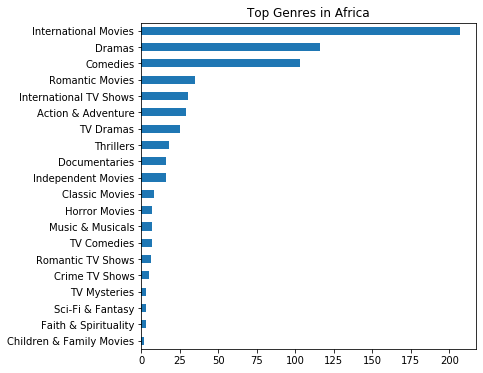

In [11]:
africa.graph_freq_dist_by_genre(africa.regional_data, 'african_content', 20)

### Latin America

In [12]:
# Instantiate Region object for Latin America, generate profile, show example movies and TV shows, and graph top genres.

latin_america = Region(netflix.data, latin_american_countries, regions[1])
latin_america.create_regional_df()
latin_america.split_df()
latin_america.generate_profile(agg_list=four_plus_seasons, agg_key=mult_seasons)
latin_america.movie_data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
show_id,,,,,,,,,,,,,,,,,,,,
s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,[Jorge Michel Grau],"[Demián Bichir, Héctor Bonilla, Oscar Serrano,...",[Mexico],"[Dramas, International Movies]",1,6,1,2
s93,Movie,"27, el club de los malditos",Nicanor Loreti,"Diego Capusotto, Sofía Gala, Daniel Aráoz, Wil...",Argentina,2018-05-01,2018,TV-MA,82,"Action & Adventure, Comedies, International Mo...",After a musician dies under suspicious circums...,2018.0,[Nicanor Loreti],"[Diego Capusotto, Sofía Gala, Daniel Aráoz, Wi...",[Argentina],"[Action & Adventure, Comedies, International M...",1,8,1,3
s147,Movie,A 3 Minute Hug,Everardo González,Unknown,"Mexico, United States",2019-10-28,2019,TV-PG,28,"Documentaries, International Movies",This documentary captures the joy and heartbre...,2019.0,[Everardo González],[Unknown],"[Mexico, United States]","[Documentaries, International Movies]",1,1,2,2


In [13]:
latin_america.tv_data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
show_id,,,,,,,,,,,,,,,,,,,,
s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,[Unknown],"[João Miguel, Bianca Comparato, Michel Gomes, ...",[Brazil],"[International TV Shows, TV Dramas, TV Sci-Fi ...",1,11,1,3
s13,TV Show,1994,Diego Enrique Osorno,Unknown,Mexico,2019-05-17,2019,TV-MA,1 Season,"Crime TV Shows, Docuseries, International TV S...",Archival video and new interviews examine Mexi...,2019.0,[Diego Enrique Osorno],[Unknown],[Mexico],"[Crime TV Shows, Docuseries, International TV ...",1,1,1,3
s219,TV Show,A Queen Is Born,Carla Barros,"Gloria Groove, Alexia Twister",Brazil,2020-11-11,2020,TV-14,1 Season,"International TV Shows, Reality TV",Gloria Groove and Alexia Twister make drag dre...,2020.0,[Carla Barros],"[Gloria Groove, Alexia Twister]",[Brazil],"[International TV Shows, Reality TV]",1,2,1,2


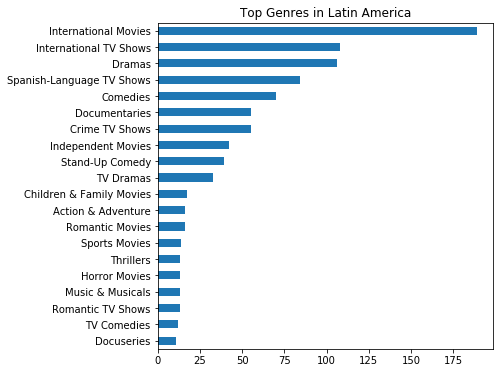

In [14]:
latin_america.graph_freq_dist_by_genre(latin_america.regional_data, 'latin_american_content', 20)

### Asia & The Pacific

In [15]:
# Instantiate Region object for Asia & The Pacific, generate profile, show example movies and TV shows, and graph top genres.

asia_pac = Region(netflix.data, asia_pac_countries, regions[2])
asia_pac.create_regional_df()
asia_pac.split_df()
asia_pac.generate_profile(agg_list=four_plus_seasons, agg_key=mult_seasons)
asia_pac.movie_data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
show_id,,,,,,,,,,,,,,,,,,,,
s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018.0,[Gilbert Chan],"[Tedd Chan, Stella Chung, Henley Hii, Lawrence...",[Singapore],"[Horror Movies, International Movies]",1,9,1,2
s9,Movie,706,Shravan Kumar,"Divya Dutta, Atul Kulkarni, Mohan Agashe, Anup...",India,2019-04-01,2019,TV-14,118,"Horror Movies, International Movies","When a doctor goes missing, his psychiatrist w...",2019.0,[Shravan Kumar],"[Divya Dutta, Atul Kulkarni, Mohan Agashe, Anu...",[India],"[Horror Movies, International Movies]",1,9,1,2
s10,Movie,1920,Vikram Bhatt,"Rajneesh Duggal, Adah Sharma, Indraneil Sengup...",India,2017-12-15,2008,TV-MA,143,"Horror Movies, International Movies, Thrillers",An architect and his wife move into a castle t...,2017.0,[Vikram Bhatt],"[Rajneesh Duggal, Adah Sharma, Indraneil Sengu...",[India],"[Horror Movies, International Movies, Thrillers]",1,8,1,3


In [16]:
asia_pac.tv_data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
show_id,,,,,,,,,,,,,,,,,,,,
s25,TV Show,​SAINT SEIYA: Knights of the Zodiac,Unknown,"Bryson Baugus, Emily Neves, Blake Shepard, Pat...",Japan,2020-01-23,2020,TV-14,2 Seasons,"Anime Series, International TV Shows",Seiya and the Knights of the Zodiac rise again...,2020.0,[Unknown],"[Bryson Baugus, Emily Neves, Blake Shepard, Pa...",[Japan],"[Anime Series, International TV Shows]",1,12,1,2
s52,TV Show,100 Days My Prince,Unknown,"Doh Kyung-soo, Nam Ji-hyun, Cho Seong-ha, Cho ...",South Korea,2020-12-07,2018,TV-14,1 Season,"International TV Shows, Romantic TV Shows, TV ...","Upon losing his memory, a crown prince encount...",2020.0,[Unknown],"[Doh Kyung-soo, Nam Ji-hyun, Cho Seong-ha, Cho...",[South Korea],"[International TV Shows, Romantic TV Shows, TV...",1,6,1,3
s62,TV Show,12 Years Promise,Unknown,"So-yeon Lee, Namkoong Min, Tae-im Lee, So-hui ...",South Korea,2017-05-22,2014,TV-14,1 Season,"International TV Shows, Korean TV Shows, Roman...",A pregnant teen is forced by her family to lea...,2017.0,[Unknown],"[So-yeon Lee, Namkoong Min, Tae-im Lee, So-hui...",[South Korea],"[International TV Shows, Korean TV Shows, Roma...",1,6,1,3


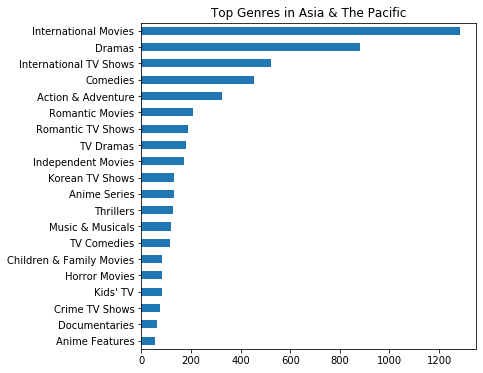

In [17]:
asia_pac.graph_freq_dist_by_genre(asia_pac.regional_data, 'asia_pacific_content', 20)

### Middle East

In [18]:
# Instantiate Region object for the Middle East, generate profile, show example movies and TV shows, and graph top genres.

middle_east = Region(netflix.data, middle_east_countries, regions[3])
middle_east.create_regional_df()
middle_east.split_df()
middle_east.generate_profile(agg_list=four_plus_seasons, agg_key=mult_seasons)
middle_east.movie_data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
show_id,,,,,,,,,,,,,,,,,,,,
s41,Movie,Çarsi Pazar,Muharrem Gülmez,"Erdem Yener, Ayhan Taş, Emin Olcay, Muharrem G...",Turkey,2017-03-10,2015,TV-14,97,"Comedies, International Movies",The slacker owner of a public bath house ralli...,2017.0,[Muharrem Gülmez],"[Erdem Yener, Ayhan Taş, Emin Olcay, Muharrem ...",[Turkey],"[Comedies, International Movies]",1,10,1,2
s43,Movie,Çok Filim Hareketler Bunlar,Ozan Açıktan,"Ayça Erturan, Aydan Taş, Ayşegül Akdemir, Burc...",Turkey,2017-03-10,2010,TV-MA,99,"Comedies, International Movies",Vignettes of the summer holidays follow vacati...,2017.0,[Ozan Açıktan],"[Ayça Erturan, Aydan Taş, Ayşegül Akdemir, Bur...",[Turkey],"[Comedies, International Movies]",1,15,1,2
s136,Movie,7 Din Mohabbat In,"Meenu Gaur, Farjad Nabi","Mahira Khan, Sheheryar Munawar, Javed Sheikh, ...",Pakistan,2019-05-15,2018,TV-PG,137,"Comedies, International Movies, Music & Musicals",Given just seven days by a genie to find a gir...,2019.0,"[Meenu Gaur, Farjad Nabi]","[Mahira Khan, Sheheryar Munawar, Javed Sheikh,...",[Pakistan],"[Comedies, International Movies, Music & Music...",2,10,1,3


In [19]:
middle_east.tv_data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
show_id,,,,,,,,,,,,,,,,,,,,
s6,TV Show,46,Serdar Akar,"Erdal Beşikçioğlu, Yasemin Allen, Melis Birkan...",Turkey,2017-07-01,2016,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Mysteries",A genetics professor experiments with a treatm...,2017.0,[Serdar Akar],"[Erdal Beşikçioğlu, Yasemin Allen, Melis Birka...",[Turkey],"[International TV Shows, TV Dramas, TV Mysteries]",1,10,1,3
s46,TV Show,Şubat,Unknown,"Alican Yücesoy, Melisa Sözen, Musa Uzunlar, Se...",Turkey,2017-01-17,2013,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Dramas",An orphan subjected to tests that gave him sup...,2017.0,[Unknown],"[Alican Yücesoy, Melisa Sözen, Musa Uzunlar, S...",[Turkey],"[Crime TV Shows, International TV Shows, TV Dr...",1,10,1,3
s81,TV Show,20 Minutes,Unknown,"Tuba Büyüküstün, Ilker Aksum, Bülent Emin Yara...",Turkey,2017-08-15,2013,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Dramas","When his wife is convicted of murder, a horrif...",2017.0,[Unknown],"[Tuba Büyüküstün, Ilker Aksum, Bülent Emin Yar...",[Turkey],"[Crime TV Shows, International TV Shows, TV Dr...",1,8,1,3


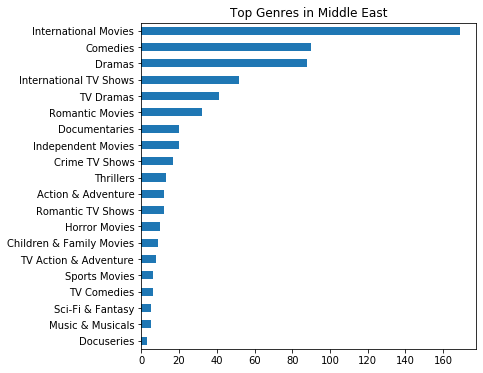

In [20]:
middle_east.graph_freq_dist_by_genre(middle_east.regional_data, 'middle_east_content', 20)

### Europe

In [21]:
# Instantiate Region object for Europe, generate profile, show example movies and TV shows, and graph top genres.

europe = Region(netflix.data, european_countries, regions[4])
europe.create_regional_df()
europe.split_df()
europe.generate_profile(agg_list=four_plus_seasons, agg_key=mult_seasons)
europe.movie_data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
show_id,,,,,,,,,,,,,,,,,,,,
s18,Movie,22-Jul,Paul Greengrass,"Anders Danielsen Lie, Jon Øigarden, Jonas Stra...","Norway, Iceland, United States",2018-10-10,2018,R,144,"Dramas, Thrillers","After devastating terror attacks in Norway, a ...",2018.0,[Paul Greengrass],"[Anders Danielsen Lie, Jon Øigarden, Jonas Str...","[Norway, Iceland, United States]","[Dramas, Thrillers]",1,7,3,2
s20,Movie,'89,Unknown,"Lee Dixon, Ian Wright, Paul Merson",United Kingdom,2018-05-16,2017,TV-PG,87,Sports Movies,"Mixing old footage with interviews, this is th...",2018.0,[Unknown],"[Lee Dixon, Ian Wright, Paul Merson]",[United Kingdom],[Sports Movies],1,3,1,1
s29,Movie,#AnneFrank - Parallel Stories,"Sabina Fedeli, Anna Migotto","Helen Mirren, Gengher Gatti",Italy,2020-07-01,2019,TV-14,95,"Documentaries, International Movies","Through her diary, Anne Frank's story is retol...",2020.0,"[Sabina Fedeli, Anna Migotto]","[Helen Mirren, Gengher Gatti]",[Italy],"[Documentaries, International Movies]",2,2,1,2


In [22]:
europe.tv_data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
show_id,,,,,,,,,,,,,,,,,,,,
s12,TV Show,1983,Unknown,"Robert Więckiewicz, Maciej Musiał, Michalina O...","Poland, United States",2018-11-30,2018,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Dramas","In this dark alt-history thriller, a naïve law...",2018.0,[Unknown],"[Robert Więckiewicz, Maciej Musiał, Michalina ...","[Poland, United States]","[Crime TV Shows, International TV Shows, TV Dr...",1,12,2,3
s59,TV Show,100% Hotter,Unknown,"Daniel Palmer, Melissa Sophia, Karen Williams,...",United Kingdom,2019-11-01,2017,TV-14,1 Season,"British TV Shows, International TV Shows, Real...","A stylist, a hair designer and a makeup artist...",2019.0,[Unknown],"[Daniel Palmer, Melissa Sophia, Karen Williams...",[United Kingdom],"[British TV Shows, International TV Shows, Rea...",1,4,1,3
s86,TV Show,21 Again,Unknown,Laura Morgan,United Kingdom,2020-07-01,2019,TV-MA,1 Season,"British TV Shows, Reality TV","In a social experiment, a group of daughters s...",2020.0,[Unknown],[Laura Morgan],[United Kingdom],"[British TV Shows, Reality TV]",1,1,1,2


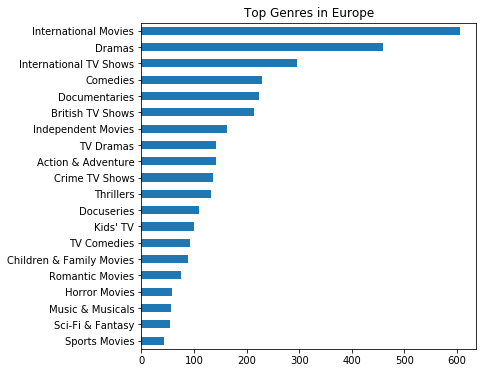

In [23]:
europe.graph_freq_dist_by_genre(europe.regional_data, 'european_content', 20)

### North America

In [24]:
# Instantiate Region object for North America, generate profile, show example movies and TV shows, and graph top genres.

north_america = Region(netflix.data, north_american_countries, regions[5])
north_america.create_regional_df()
north_america.split_df()
north_america.generate_profile(agg_list=four_plus_seasons, agg_key=mult_seasons)
north_america.movie_data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
show_id,,,,,,,,,,,,,,,,,,,,
s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017.0,[Shane Acker],"[Elijah Wood, John C. Reilly, Jennifer Connell...",[United States],"[Action & Adventure, Independent Movies, Sci-F...",1,9,1,3
s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123,Dramas,A brilliant group of students become card-coun...,2020.0,[Robert Luketic],"[Jim Sturgess, Kevin Spacey, Kate Bosworth, Aa...",[United States],[Dramas],1,12,1,1
s8,Movie,187,Kevin Reynolds,"Samuel L. Jackson, John Heard, Kelly Rowan, Cl...",United States,2019-11-01,1997,R,119,Dramas,After one of his high school students attacks ...,2019.0,[Kevin Reynolds],"[Samuel L. Jackson, John Heard, Kelly Rowan, C...",[United States],[Dramas],1,5,1,1


In [25]:
north_america.tv_data.head(3)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,director_list,cast_list,country_list,listed_in_list,director_size,cast_size,country_size,listed_in_size
show_id,,,,,,,,,,,,,,,,,,,,
s12,TV Show,1983,Unknown,"Robert Więckiewicz, Maciej Musiał, Michalina O...","Poland, United States",2018-11-30,2018,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Dramas","In this dark alt-history thriller, a naïve law...",2018.0,[Unknown],"[Robert Więckiewicz, Maciej Musiał, Michalina ...","[Poland, United States]","[Crime TV Shows, International TV Shows, TV Dr...",1,12,2,3
s27,TV Show,(Un)Well,Unknown,Unknown,United States,2020-08-12,2020,TV-MA,1 Season,Reality TV,This docuseries takes a deep dive into the luc...,2020.0,[Unknown],[Unknown],[United States],[Reality TV],1,1,1,1
s30,TV Show,#blackAF,Unknown,"Kenya Barris, Rashida Jones, Iman Benson, Genn...",United States,2020-04-17,2020,TV-MA,1 Season,TV Comedies,Kenya Barris and his family navigate relations...,2020.0,[Unknown],"[Kenya Barris, Rashida Jones, Iman Benson, Gen...",[United States],[TV Comedies],1,7,1,1


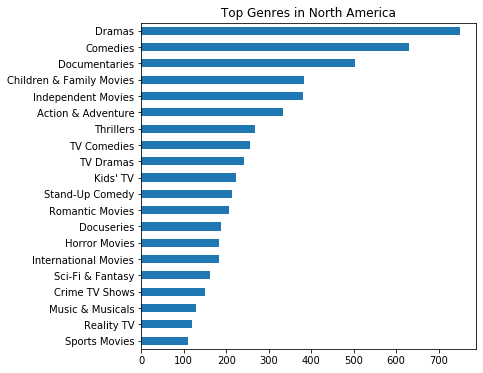

In [26]:
north_america.graph_freq_dist_by_genre(north_america.regional_data, 'north_american_content', 20)

## Compare Regions

In [27]:
# Create list of profiles from each region and use it to instantiate a Comparison object.

profiles = [
    africa.profile,
    latin_america.profile,
    asia_pac.profile,
    middle_east.profile,
    europe.profile,
    north_america.profile
]

region_compare = Comparison(profiles)
region_compare.create_df(regions)
region_compare.compare_df

,show_dist,avg_movie_length,tv_length_dist,avg_director_count,avg_cast_size,avg_country_count,avg_genre_count,first_year_on_netflix,release_year_span
Africa,"{'Movie': 87.83, 'TV Show': 12.17}",105.41,"{'1 Season': 90.62, '2 Seasons': 9.38}",1.06,7.92,1.43,2.48,2014.0,"(1954, 2020)"
Latin America,"{'Movie': 68.4, 'TV Show': 31.6}",89.92,"{'1 Season': 73.44, '2 Seasons': 16.41, '3 Sea...",1.15,7.63,1.56,2.42,2011.0,"(1979, 2021)"
Asia & The Pacific,"{'Movie': 70.72, 'TV Show': 29.28}",117.13,"{'1 Season': 78.07, '2 Seasons': 13.84, '3 Sea...",1.08,7.96,1.25,2.57,2015.0,"(1959, 2021)"
Middle East,"{'Movie': 77.64, 'TV Show': 22.36}",103.57,"{'1 Season': 74.55, '2 Seasons': 12.73, '3 Sea...",1.10,7.64,1.67,2.57,2016.0,"(1975, 2021)"
Europe,"{'Movie': 68.29, 'TV Show': 31.71}",98.32,"{'1 Season': 63.5, '2 Seasons': 18.06, '3 Seas...",1.09,7.24,1.81,2.30,2009.0,"(1944, 2021)"
North America,"{'Movie': 73.32, 'TV Show': 26.68}",91.93,"{'1 Season': 51.33, '2 Seasons': 18.64, '3 Sea...",1.11,7.29,1.36,1.83,2008.0,"(1942, 2021)"


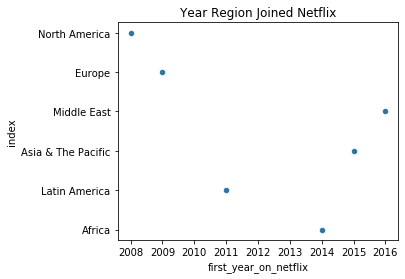

In [28]:
# Timeline of when each region first added content to Netflix.
region_compare.plot_timeline()

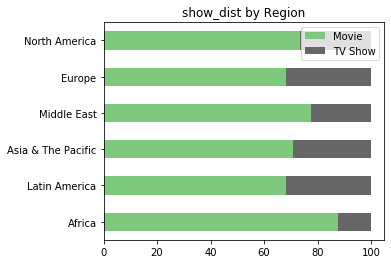

In [29]:
# Proportion of movies and TV shows for each region.
region_compare.plot_stacked_bar('show_dist')

plt.savefig('charts/distribution_by_type_region.png')

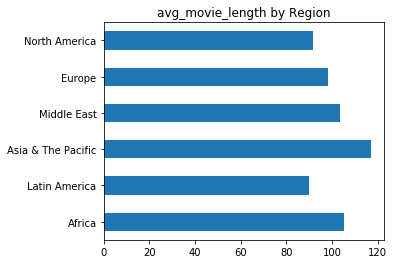

In [30]:
# Average movie length for each region.
region_compare.plot_bar('avg_movie_length')

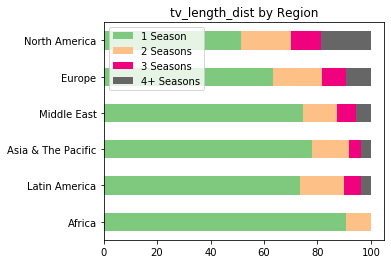

In [31]:
# Proportion of TV shows that lasted 1, 2, 3, or more seasons for each region.
region_compare.plot_stacked_bar('tv_length_dist')

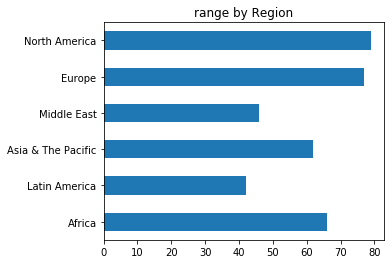

In [32]:
# The difference between the oldest and the newest content for each year, in terms of when it was originally released.
region_compare.calc_range()
region_compare.plot_bar('range')

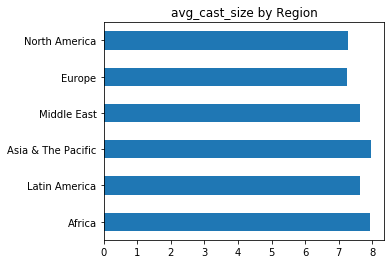

In [33]:
# Average number of cast members for each region.
region_compare.plot_bar('avg_cast_size')

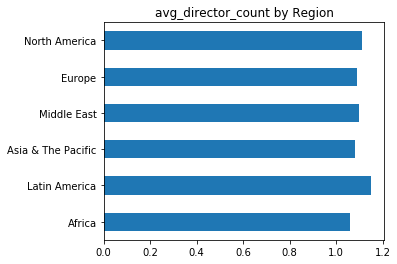

In [34]:
# Average number of directors for each region.
region_compare.plot_bar('avg_director_count')

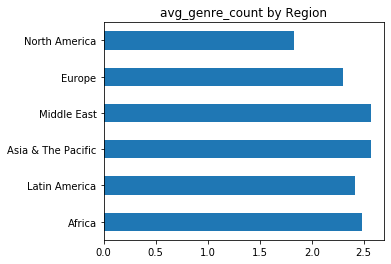

In [35]:
# Average number of genres for each region.
region_compare.plot_bar('avg_genre_count')

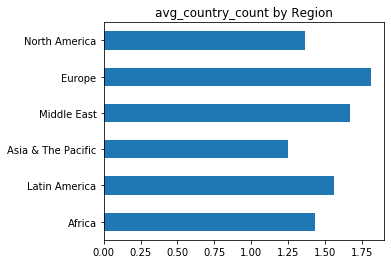

In [36]:
# Average number of countries each show involves for each region.
region_compare.plot_bar('avg_country_count')